<a href="https://colab.research.google.com/github/sauravkb94/DNA-Sequencing-Classifier-/blob/main/DNA_Sequencing_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [196]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [197]:
df = pd.read_table('/content/human.txt')

In [198]:
df

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3
...,...,...
4375,ATGGAAGATTTGGAGGAAACATTATTTGAAGAATTTGAAAACTATT...,0
4376,ATGCAGTCCTTTCGGGAGCAAAGCAGTTACCACGGAAACCAGCAAA...,6
4377,ATGCAGTCCTTTCGGGAGCAAAGCAGTTACCACGGAAACCAGCAAA...,6
4378,ATGGGGCACCTGGTTTGCTGTCTGTGTGGCAAGTGGGCCAGTTACC...,6


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


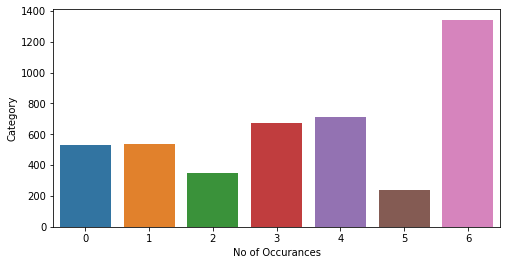

In [199]:
count = df['class'].value_counts()
plt.figure(figsize= (8,4))
sns.barplot(count.index, count.values)
plt.xlabel('No of Occurances')
plt.ylabel('Category');

In [200]:
df['length'] = df['sequence'].apply(len)

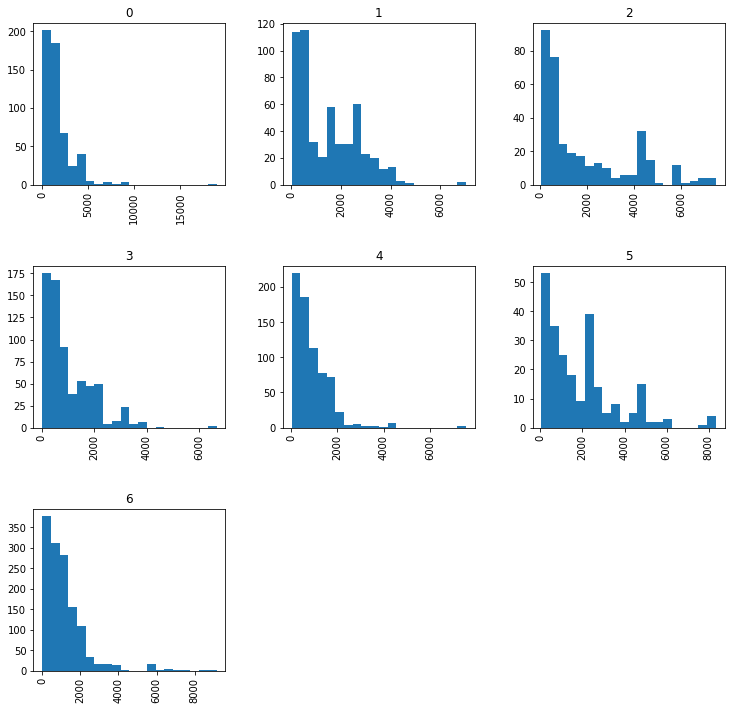

In [201]:
df.hist(column= 'length', by = 'class', bins = 20, figsize=(12,12) );

**Let's define a function to collect all possible overlapping n-grams of a specified length from any sequence string. We will basically apply the n-grams to the complete sequences.**

In [202]:
# function to convert sequence strings into n-grams words, default size = 6 (hexamer words)
def create_ngrams(sequence, size=6):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

In [203]:
df['n-grams'] = df['sequence'].apply(create_ngrams)

In [204]:
df.head(10)

,sequence,class,length,n-grams
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4,207,"[atgccc, tgcccc, gcccca, ccccaa, cccaac, ccaac..."
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4,681,"[atgaac, tgaacg, gaacga, aacgaa, acgaaa, cgaaa..."
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3,1686,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3,1206,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3,1437,"[atgcaa, tgcaac, gcaaca, caacag, aacagc, acagc..."
5,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3,1686,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
6,ATGAAGATTGCACACAGAGGTCCAGATGCATTCCGTTTTGAGAATG...,3,1623,"[atgaag, tgaaga, gaagat, aagatt, agattg, gattg..."
7,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3,1437,"[atgcaa, tgcaac, gcaaca, caacag, aacagc, acagc..."
8,ATGAAGATTGCACACAGAGGTCCAGATGCATTCCGTTTTGAGAATG...,3,1623,"[atgaag, tgaaga, gaagat, aagatt, agattg, gattg..."
9,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3,644,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."


**Since we are going to use scikit-learn natural language processing tools to do the k-mer counting, we need to now convert the lists of k-mers for each gene into string sentences of words that the count vectorizer can use. We can also make a y variable to hold the class labels. Let's do that now.**

In [205]:
human_text = list(df['n-grams'])

In [206]:
for item in range(len(human_text)):
   human_text[item] = ' '.join(human_text[item])

In [207]:
human_text[1]

'atgaac tgaacg gaacga aacgaa acgaaa cgaaaa gaaaat aaaatc aaatct aatctg atctgt tctgtt ctgttc tgttcg gttcgc ttcgct tcgctt cgcttc gcttca cttcat ttcatt tcattc cattca attcat ttcatt tcattg cattgc attgcc ttgccc tgcccc gccccc ccccca ccccac cccaca ccacaa cacaat acaatc caatcc aatcct atccta tcctag cctagg ctaggc taggcc aggcct ggccta gcctac cctacc ctaccc tacccg acccgc cccgcc ccgccg cgccgc gccgca ccgcag cgcagt gcagta cagtac agtact gtactg tactga actgat ctgatc tgatca gatcat atcatt tcattc cattct attcta ttctat tctatt ctattt tatttc atttcc tttccc ttcccc tccccc ccccct cccctc ccctct cctcta ctctat tctatt ctattg tattga attgat ttgatc tgatcc gatccc atcccc tcccca ccccac cccacc ccacct cacctc acctcc cctcca ctccaa tccaaa ccaaat caaata aaatat aatatc atatct tatctc atctca tctcat ctcatc tcatca catcaa atcaac tcaaca caacaa aacaac acaacc caaccg aaccga accgac ccgact cgacta gactaa actaat ctaatc taatca aatcac atcacc tcacca caccac accacc ccaccc caccca acccaa cccaac ccaaca caacaa aacaat acaatg caatga aatgac atgact tgacta gacta

In [208]:
df['human_text'] = human_text

In [209]:
df.head(5)

,sequence,class,length,n-grams,human_text
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4,207,"[atgccc, tgcccc, gcccca, ccccaa, cccaac, ccaac...",atgccc tgcccc gcccca ccccaa cccaac ccaact caac...
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4,681,"[atgaac, tgaacg, gaacga, aacgaa, acgaaa, cgaaa...",atgaac tgaacg gaacga aacgaa acgaaa cgaaaa gaaa...
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3,1686,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca...",atgtgt tgtgtg gtgtgg tgtggc gtggca tggcat ggca...
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3,1206,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca...",atgtgt tgtgtg gtgtgg tgtggc gtggca tggcat ggca...
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3,1437,"[atgcaa, tgcaac, gcaaca, caacag, aacagc, acagc...",atgcaa tgcaac gcaaca caacag aacagc acagca cagc...


**Now we will apply the BAG of WORDS using CountVectorizer using NLP**

In [210]:
# Creating the Bag of Words model using CountVectorizer()
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(4,4))
X = vectorizer.fit_transform(df['human_text'])

In [211]:
df.shape

(4380, 5)

In [212]:
X.shape

(4380, 232414)

In [213]:
# Creating the weight of Words model using TfidfTransformer()
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_data = TfidfTransformer().fit_transform(X)

In [214]:
tfidf_data.shape

(4380, 232414)

In [215]:
# Splitting the human dataset into the training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tfidf_data, 
                                                df['class'], 
                                                    test_size = 0.20, 
                                                    random_state=42)

In [216]:
X_train.shape

(3504, 232414)

In [217]:
X_test.shape

(876, 232414)

**A multinomial naive Bayes classifier will be created. .**

In [218]:
### Multinomial Naive Bayes Classifier ###
# The alpha parameter was determined by grid search previously
from sklearn.naive_bayes import MultinomialNB


In [219]:
classifier = MultinomialNB(alpha=0.1)
classifier.fit(X_train, y_train)

MultinomialNB(alpha=0.1)

In [220]:
y_pred = classifier.predict(X_test)

 **Model performce metrics like the confusion matrix, accuracy, precision, recall and f1 score**

In [221]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("Confusion matrix\n")
print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(preds, name='Predicted')))


Confusion matrix

Predicted  0  1  2  3  4  5   6
Actual                         
0          2  0  0  1  1  1  12
1          3  2  0  7  7  0  15
2          0  0  1  3  3  0  12
3          1  0  2  5  2  0  11
4          5  5  2  4  2  0  16
5          2  1  1  2  1  0   3
6          5  5  3  5  5  0  34


In [222]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("Confusion matrix\n")
print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(preds, name='Predicted')))
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion matrix

Predicted  0  1  2  3  4  5   6
Actual                         
0          2  0  0  1  1  1  12
1          3  2  0  7  7  0  15
2          0  0  1  3  3  0  12
3          1  0  2  5  2  0  11
4          5  5  2  4  2  0  16
5          2  1  1  2  1  0   3
6          5  5  3  5  5  0  34
accuracy = 0.977 
precision = 0.977 
recall = 0.977 
f1 = 0.977
